# SERDES Quadrature Sampling Detector

Rob Riggs, Mobilinkd LLC, 2021

## Abstract

Can SERDES hardware on modern FPGAs be used as a 1-bit ADC for reception
of RF signals?  This is an interesting avenue for exploration because it
opens up a possibilities for reducing the cost of RF designs that already
encorporate an FPGA for digital signal processing.  This paper describes
the use of Xilinx Zynq-7020 differential I/O SERDES for the reception of
M17 4-FSK digital signals on the 2m amateur radio band.  Using the
techniques described in this paper, we show that reception is indeed
possible and, with further research, can be extended to microwave
applications by using gigabit transceivers common on modern FPGAs.

## Introduction

RF transceiver ICs available today typically fall into one of 4 categories:

    1. Inexpense purpose-built devices that have limited functionality.
       These are typically designed to interface with a microcontroller.
    2. General purpose devices that can be used to output wide-band IQ
       data streams which are typically rather expensive and require an
       FPGA to process the data streams.
    3. High-speed RF DACs. Again, expensive and which require an FPGA
       or dedicated hardware to process baseband.
    4. RFSoC devices -- FPGAs with dedicated RF DACs. These are at the top
       end of the price spectrum.

All of the general purpose devices are expensive and require either an FPGA
or dedicated hardware to process baseband.  What if the needs of the system
fall between 1 & 2?  The user has special needs which are not met by
commercial off-the-shelf (COTS) components, but are not demanding enough
to warrant the cost of a device like an AD9361?

What options exist if we are going to use an FPGA to implement baseband
processing anyway?

This is the problem we faced when designing an RF system for M17, a new
digital voice & data protocol developed by the amateur radio community.
It required a radio capable of fairly narrow 4-FSK using an RRC matched
filter with an alpha of 0.5.  There are chips available that do 4-FSK,
but most use Gaussian filtering, do raised cosine rather that root
Nyquist filtering, or use different alpha values for the filter.

Can we use the features available on a modern FPGA for RF? The answers is
"yes, we can."

In this paper we describe a receiver which uses an FPGA's I/O SERDES
(SERializer/DESerializer) resources for direct I/Q sampling.  No
specialized RF ICs are required to receive and demodulate complex RF
signals.

## Quadrature Sampling Detector

Dan Tayloe N7VE invented the quadrature sampling detector or *Tayloe
Mixer*, which is decribed in [Ultra Low Noise, High Performance, Zero IF Quadrature
Product Detector and Preamplifier](http://www.norcalqrp.org/files/Tayloe_mixer_x3a.pdf).

![Tayloe Mixer](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSJvoCs6r1Z_TTS0LUkETXj6VbRjTgooWJ_7A&usqp=CAU)

A quadrature sampling detector is simply an RF source connected to an
analog switch, which samples the input at the RF frequency one quarter
cycle at a time, feeding those samples into a pair of integrators.
The integrators downsample to baseband.  The baseband bandwidth is
determined by the effective low-pass filtering of the integrator.

## Integrating a 1-bit DAC

Our contribution is showing that this sampling can be done directly in
an FPGA, using a SERDES differential input to capture VHF, UHF and
SHF RF.




The use of 1-bit DACs and 1-bit ADCs for analog signal processing is
well established at this point.  This paper extends that work in a way
that allows us to use SERDES hardware in modern FPGAs as a high-speed
1-bit ADC to acquire RF signals and, using modern digital signal
processing techniques, to increase the effective number of bits (ENOB)
to a usable value for demodulating complex, if somewhat narrow-band,
baseband signals.

We describe the design of a quadrature sampling detector (QSD) using an
FPGA and characterize its performance.  It is able to receive up to
225MHz (the amateur 1.25m band).  The implemented design has
bandwidth of 48kHz, more than enough for narrow-band FM (NFM).  However,
this limit is an implementation detail and not a fundamental limit
of the conceptual design.

In this paper we describe the differences between an analog QSD
implementation and one that is done mostly in the digital realm. And we
describe the RF-to-FPGA interface required to be able to implement
the quadrature sampling detector.  Finally, we characterize the
performance of the system.

## The Problem

In late 2021, electronic chip shortages affected the global economy.
This affected a wide range of chips, including RF chips.  We are
working on hardware and software designed for a new narrow-band digital
voice protocol, M17.  Many of the most desireable choices were not
available for purchase and lead times were unknown.  The old adage
"necessity is the mother of invention" is at play here.



I discovered that by configuring the FPGA I/O to directly
sample RF a the desired receive frequency using 4x oversampling I was able
to implement a quadrature sampling detector (QSD) in an FPGA.

A quadrature sampling detector operates at the RF receiver frequency. In an
analog QSD, baseband IQ signals are recovered using a pair of integrators.

In an FPGA we use a multi-stage CIC decimation filter with M ≈ 600 to
perform this integration.  Using this method, one can acheive an effective
resolution (ENOB) of 16 bits.  The ENOB can be increased using more stages.



We provide a basic hardware implementation designed to interface an
unbalanced RF input to a differential I/O pair on the FPGA.  We used two
designs -- one interfacing with a PMOD on a Pynq-Z2 and the other which
interfaces with the TMDS lines via the HDMI input in the Pynq-Z2 board.

We describe the overall architecture of the QSD in an FPGA.  This
includes a Xilinx System Integrator block design and some basic blocks
designed using Vitis HLS.  We tie this all together using a Jupyter
notebook and Python to load the bitstream into the FPGA.

All of the hardware, HLS, and software are released under various open
source and open hardware licenses. This paper is also released under
an open license.

Part of this receiver is based on work done on an arbitrary
clock generator (or NCO) for Pynq in 2019.

In this paper I describe how to 

This ACG work was inspired by two things.  First, I was playing around with
an Adafruit Si5351A module, trying to make a quadrature clock for testing
a Quadrature Sampling Detector (QSD), also known as a
[Tayloe Mixer](https://wparc.us/presentations/SDR-2-19-2013/Tayloe_mixer_x3a.pdf),
and noticed that the phase and duty cycle change based on frequency.  I have
no idea if this causes a problem at the HF and low VHF frequencies of
interest (6m - 160m amateur radio bands), but it seemed less than ideal.

Second was discovering [an article](https://zipcpu.com/blog/2019/06/28/genclk.html)
by Dan Gisselquist [@ZipCPU](https://twitter.com/zipcpu) on implementing an
arbitrary clock generator for an Artix-7 board.  I had been thinking about
doing such a thing but I was an FPGA newbie and didn't really know where to
start.  Most of what I needed to implement this for Pynq is available in Vivado
IP Integrator.  The remaining bits were trivial to implement in HLS.

The NCO uses a high-speed (for the Zynq-7020) SERDES output to generate a
very rough clock signal.  This is then fed into a clock input ping and cleaned
up with a PLL, providing a very stable clock.  The PLL has a wide lock range.
As long as we stay within the bounds of the PLL's input range, we can create
an accurate and clean clock signal.

This clock is then used to drive another SERDES pin that outputs a constant
010101... signal using DDR at 4x the input frequency.  The maximum output
frequency is 900MHz; the maximum TX frequency is half that.

This means we can cover up to the top of the 70cm band.

So, let's get started.

## Project Organization

This project is organized into 4 key components.

 1. This top-level document.
 2. The HLS code to implement the fractional divider.
 3. The Vivado IP Integrator project and block design.
 4. The Pynq code, implemented as [another notebook](Pynq/acg-pynq.ipynb).

# Table of Contents

# Requirements

As a software engineer, I always like to start with the requirements of a project
before getting started so I know what I am aiming for.  Since this is an exploratory
project, the requirements are more along the lines of "see if this will work" but
lets see what I am aiming for.

I am considering creating a low-power amateur radio transceiver, starting with a
receiver and eventually progressing to a transmitter, capable of 160m - 6m
(1.8-54.0MHz), using a QSD.  This requires two clock outputs in quadrature
(90 degrees phase offset).  We would like tuning precision to be within 1Hz over
the whole range, but we can live with less precision if necessary.  We would like
phase jitter to be below 100ps and duty cycle to be 50% +/- 0.5%.


# Fractional Clock Divider

We are going to generate a 32-bit fractional clock divider.  To get the precision
I am aiming for, I need only 24 bits, but old habits die hard.  And the example I
am basing this off of used 32 bits.

The code is pretty straight-forward.  Our interface takes a increment and
forever generates a clock based on this value. To disable it, set the increment to 0.
The increment is used to update an accumulator the clock (mostly).

The output sample rate $r$ is 800Msps.  To calculate the increment $i$  for the
desired frequency $f$ :

$i = \frac{(2^{32} r)}{f}$

----


```C++
#include <ap_int.h>

constexpr size_t DIVIDER=32;
constexpr size_t UPSAMPLE=8;

typedef ap_uint<DIVIDER> delay_type;
typedef ap_uint<UPSAMPLE> output_type;

output_type acg_top(delay_type inc);
```

The top-level function accepts the increment and returns up-sampled data to generate
the clock via an 8-bit DDR OSERDES interface.  We generate 8 output bits every clock
cycle.  We do this by creating 8 accumulators (0..7) and adding inc \* n to these, then
taking the high bit of each.

```C++
#include "acg_top.hpp"

output_type acg_top(delay_type inc)
{
#pragma HLS INTERFACE s_axilite port=inc
#pragma HLS INTERFACE ap_ctrl_none port=return
#pragma HLS latency max=0

	static ap_uint<DIVIDER> accumulator[UPSAMPLE];
	ap_uint<DIVIDER> delay[UPSAMPLE];
	output_type clock_out;

    // Generate the delay values by calculating the n delays.
	delay[0] = inc;
	delay[1] = inc << 1;
	delay[3] = inc << 2;
	delay[7] = inc << 3;
	delay[2] = delay[1] + delay[0];
	delay[4] = delay[3] + delay[0];
	delay[5] = delay[1] + delay[3];
	delay[6] = delay[7] - delay[0];

    // Add the increments to the base accumulator.
	accumulator[1] = accumulator[0] + delay[0];
	accumulator[2] = accumulator[0] + delay[1];
	accumulator[3] = accumulator[0] + delay[2];
	accumulator[4] = accumulator[0] + delay[3];
	accumulator[5] = accumulator[0] + delay[4];
	accumulator[6] = accumulator[0] + delay[5];
	accumulator[7] = accumulator[0] + delay[6];
	accumulator[0] = accumulator[0] + delay[7];

    // Grab the top bit of each accumulator and pack it into the output
    // byte.  Order here is important for proper serialization.  Note
    // that 0 is the largest.
	clock_out[7] = accumulator[0][DIVIDER - 1];
	clock_out[6] = accumulator[7][DIVIDER - 1];
	clock_out[5] = accumulator[6][DIVIDER - 1];
	clock_out[4] = accumulator[5][DIVIDER - 1];
	clock_out[3] = accumulator[4][DIVIDER - 1];
	clock_out[2] = accumulator[3][DIVIDER - 1];
	clock_out[1] = accumulator[2][DIVIDER - 1];
	clock_out[0] = accumulator[1][DIVIDER - 1];

	return clock_out;
}
```

That's it for the fractional clock divider.  8 bits are output each clock cycle.
The frequency can be changed on the fly via the AXI4lite interface by writing to
the inc_V variable.

# IP Integrator

To start the block design, we need to set up our board constraints.  We need 5 pins:

 1. An LED to indicate the PLL is locked.
 1. The SERDES output.  In an ideal world, this would be the same as the PLL input.
 1. The PLL input.  This must be a clock capable pin.
 1. Two pins for the quadrature clock outputs.
 
Lucky for us, PMOD A on the Pynq-Z2 works perfectly for our needs here.  We set up
the LED on one of the LEDs, and the rest are on PMOD A.  These are also available
on the Rasperry Pi connector.

```
set_property -dict { PACKAGE_PIN R14   IOSTANDARD LVCMOS33 } [get_ports { pll_locked }]; #IO_L6N_T0_VREF_34 Sch=led[0]
set_property -dict { PACKAGE_PIN Y18   IOSTANDARD LVCMOS33 SLEW FAST} [get_ports { synth_clk[0] }]; #IO_L17P_T2_34 Sch=ja_p[1]
set_property -dict { PACKAGE_PIN U18   IOSTANDARD LVCMOS33 } [get_ports { pll_in }]; #IO_L12P_T1_MRCC_34 Sch=ja_p[3]
set_property -dict { PACKAGE_PIN Y16   IOSTANDARD LVCMOS33 SLEW FAST} [get_ports { clk_i }]; #IO_L7P_T1_34 Sch=ja_p[2]
set_property -dict { PACKAGE_PIN Y17   IOSTANDARD LVCMOS33 SLEW FAST} [get_ports { clk_q }]; #IO_L7N_T1_34 Sch=ja_n[2]

```

The block design in IP integrator looks like this:

![acg-block-design.png](acg-block-design.png)



Populating the interactive namespace from numpy and matplotlib
59979.30463576159 12.495688465783665


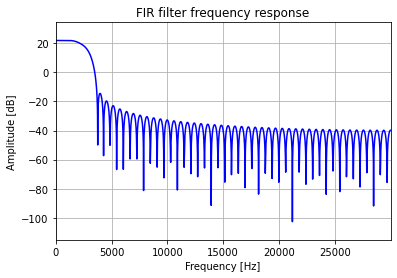

[-269, -215, -122, -1, 134, 267, 378, 450, 469, 428, 327, 176, -7, -200, -373, -499, -551, -514, -379, -153, 141, 471, 791, 1047, 1187, 1164, 942, 506, -134, -944, -1859, -2789, -3624, -4240, -4513, -4325, -3580, -2212, -198, 2442, 5638, 9273, 13187, 17190, 21072, 24617, 27622, 29908, 31338, 31825, 31338, 29908, 27622, 24617, 21072, 17190, 13187, 9273, 5638, 2442, -198, -2212, -3580, -4325, -4513, -4240, -3624, -2789, -1859, -944, -134, 506, 942, 1164, 1187, 1047, 791, 471, 141, -153, -379, -514, -551, -499, -373, -200, -7, 176, 327, 428, 469, 450, 378, 267, 134, -1, -122, -215, -269] 99


In [10]:
%pylab inline

import scipy
import scipy.signal
import numpy as np
from commpy.filters import rrcosfilter

def fir_plot(taps, fs = 240000):
    nq = fs / 2.0

    w, h = scipy.signal.freqz(taps, 1, worN = 2000)
    plt.plot((fs * 0.5 / np.pi) * w, 20 * np.log10(abs(h)), 'b')

    plt.title('FIR filter frequency response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.xlim(0, nq)

    plt.show()

m = 144910000/(302 * 8)
samples_per_symbol = m / 4800
print(m, samples_per_symbol)

taps = rrcosfilter(100, 0.5, 1, samples_per_symbol)[1][1:]

fir_plot(taps, m)

out_taps = [int(tap * 28000) for tap in taps]

print(out_taps, len(taps))

